# Credit Card Fraud Detection

In [0]:
!pip install imblearn

In [0]:
''' Linear Algebra'''
import pandas as pd
import numpy as np

''' Data visualisation'''
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix

''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


All the previous exercises made you take a closer look at all the different parts of a neural network: 
* the architecture of a sequential Dense Neural Network, 
* the compilation method
* the fitting.

Let's now work on a real-life dataset that has **a lot of data**!

**The dataset : `Credit Card Transactions`**

For this open challenge, you will `work with data extracted from credit card transactions`. 

As these are `sensitive data`, from all the 31 columns, only 3 columns are known: the rest are data that have been transformed to `anonymize` them (in fact, they are `PCA projections of initial data`).

The other three known columns are:

* `TIME`: the time elapsed between the transaction and the first transaction in the dataset
* `AMOUNT`: the amount of the transaction
* `CLASS` (our target): 
    * `0 : valid transaction` 
    * `1 : fraudulent transaction`

❓ **Question** ❓ Start by downloading the dataset:
* on the Kaggle website [here](https://www.kaggle.com/mlg-ulb/creditcardfraud) 
* or from our [URL](https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/creditcard.csv) 

Load data to create `X` and `y`

In [0]:
# Load data
df = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/creditcard.csv")

In [0]:
# Select data
X = df.drop(columns=['Class'],axis=1).values
y = df['Class'].values

## 1. Rebalancing classes

In [0]:
# Let's check class balance
pd.Series(y).value_counts(normalize=True)

0    0.998273
1    0.001727
dtype: float64

☝️ in this `fraud detection` challenge, **the classes are extremely imbalanced**:
* 99.8 % of normal transactions
* 0.2 % of fraudulent transactions

**We won't be able to detect frauds unless we apply some serious rebalancing strategies!**

❓ **Question** ❓
1. **First**, create three separate splits `Train/Val/Test` from your dataset. It is extremely important to keep validation and testing sets **unbalanced** so that when you evaluate your model, it is done in true conditions, without data leakage. Keep your test set for the very last cell of this notebook... !

&nbsp;
2. **Second**, rebalance you training set (and only this one). You have many choices:

- Simply oversample the minority class randomly using plain Numpy functions (not the best option since you are duplicating rows and hence creating data leakage)
- Or use <a href="https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/">**`Synthetic Minority Oversampling Technique - SMOTE`**</a> to generate new datapoints by weighting the existing ones
- In addition, you can also try a <a href="https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/">**`RandomUnderSampler`**</a> to downsample the majority class a little bit

In [0]:
# YOUR CODE HERE

In [0]:
# Train test split before any resampling to keep real test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [0]:
print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"X_val.shape = {X_val.shape}")
print(f"y_val.shape = {y_val.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (139554, 30)
y_train.shape = (139554,)
X_val.shape = (59810, 30)
y_val.shape = (59810,)
X_test.shape = (85443, 30)
y_test.shape = (85443,)


In [0]:
# How many "fraud" samples do I have in each split?
print(np.sum(y_train[y_train == 1]))
print(np.sum(y_val[y_val == 1]))
print(np.sum(y_test[y_test == 1]))

print("-"*100)

print(f"There are {pd.Series(y_train).value_counts()[1]} fraudulent transactions in the train set")
print(f"There are {pd.Series(y_val).value_counts()[1]} fraudulent transactions in the val set")
print(f"There are {pd.Series(y_test).value_counts()[1]} fraudulent transactions in the test set")

267
88
137
----------------------------------------------------------------------------------------------------
There are 267 fraudulent transactions in the train set
There are 88 fraudulent transactions in the val set
There are 137 fraudulent transactions in the test set


In [0]:
# Sampling strategies
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.33)

In [0]:
from sklearn import set_config;  set_config(display = 'diagram')

# Pipelining the two strategies
steps =  [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
pipeline

Pipeline(steps=[('o', SMOTE(sampling_strategy=0.1)),
                ('u', RandomUnderSampler(sampling_strategy=0.33))])

In [0]:
# Rebalance the dataset
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print(f"X_train_resampled.shape = {X_train_resampled.shape}")
print(f"y_train_resampled.shape = {y_train_resampled.shape}")

X_train_resampled.shape = (56134, 30)
y_train_resampled.shape = (56134,)


In [0]:
# Reshuffle the resampled data just to be sure
stacked_resampled_data = np.hstack([X_train_resampled, y_train_resampled.reshape(-1,1)])
np.random.shuffle(stacked_resampled_data)

X_train_resampled = stacked_resampled_data[:,:30]
y_train_resampled = stacked_resampled_data[:,-1]

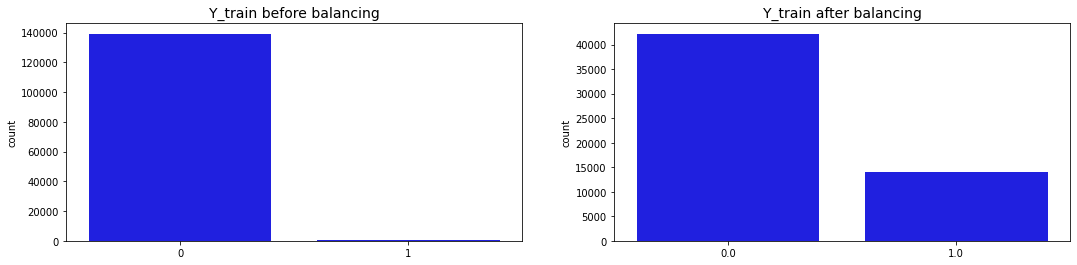

In [0]:
# plotting
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(1, 2, figsize=(18,4))

''' Before rebalancing classes'''

sns.countplot(y_train, ax=ax[0], color='b')
ax[0].set_title('Y_train before balancing', fontsize=14)

''' After rebalancing classes'''

sns.countplot(y_train_resampled, ax=ax[1], color='b')
ax[1].set_title('Y_train after balancing', fontsize=14);

In [0]:
print(X_train_resampled.shape)
print(X_val.shape)

(56134, 30)
(59810, 30)


## 2. Neural Network iterations

Now that you have rebalanced your classes, try to fit a neural network to optimize your test score. Feel free to use the following hints:

- Normalize your inputs!
    - Use preferably a [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer inside the model to "pipeline" your preprocessing within your model. 
    - Or use sklearn's [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) outside of your model, applied your `X_train` and `X_val` and `X_test`.
- Make your model overfit, then, regularize  it using:
    - Early Stopping criteria 
    - [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers
    - or [`regularizers`](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) layers
- 🚨 Think carefully about the metrics you want to track and the loss function you want to use... !


In [0]:
# YOUR CODE HERE

In [0]:
metrics = [
    keras.metrics.Recall(),
    keras.metrics.Precision(),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

2021-08-10 19:50:47.036483: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [0]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.metrics import Recall, Precision

def init_model():
    input_shape = X_train_resampled.shape[1:]
    normalizer = Normalization()
    normalizer.adapt(X_train_resampled)
    
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # Model compilation
    optimizer = Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

### Regularized model

In [0]:
model = init_model()
#model.summary()

In [0]:
es = EarlyStopping(
    patience=10,
    monitor='val_recall', # We really want to detect fraudulent transactions!
    restore_best_weights=True)

history = model.fit(X_train_resampled, y_train_resampled,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=64, # Large enough to get a decent chance of containing fraudulent transactions 
                    callbacks=[es], shuffle=True)

Epoch 1/100
878/878 [==============================] - 3s 3ms/step - loss: 0.5120 - recall: 0.3283 - precision: 0.5469 - prc: 0.5125 - val_loss: 0.0982 - val_recall: 0.5227 - val_precision: 0.6866 - val_prc: 0.5414
Epoch 2/100
878/878 [==============================] - 2s 2ms/step - loss: 0.2873 - recall: 0.5738 - precision: 0.9323 - prc: 0.8779 - val_loss: 0.0305 - val_recall: 0.7727 - val_precision: 0.5714 - val_prc: 0.5851
Epoch 3/100
878/878 [==============================] - 2s 2ms/step - loss: 0.1992 - recall: 0.7709 - precision: 0.9607 - prc: 0.9377 - val_loss: 0.0214 - val_recall: 0.8068 - val_precision: 0.4152 - val_prc: 0.6251
Epoch 4/100
878/878 [==============================] - 2s 2ms/step - loss: 0.1589 - recall: 0.8428 - precision: 0.9664 - prc: 0.9559 - val_loss: 0.0195 - val_recall: 0.8295 - val_precision: 0.2932 - val_prc: 0.6593
Epoch 5/100
878/878 [==============================] - 2s 2ms/step - loss: 0.1350 - recall: 0.8659 - precision: 0.9721 - prc: 0.9645 - val_l

In [0]:
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1,3,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- RECALL

    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    
    # --- PRECISION
    
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    
    
    plt.show()

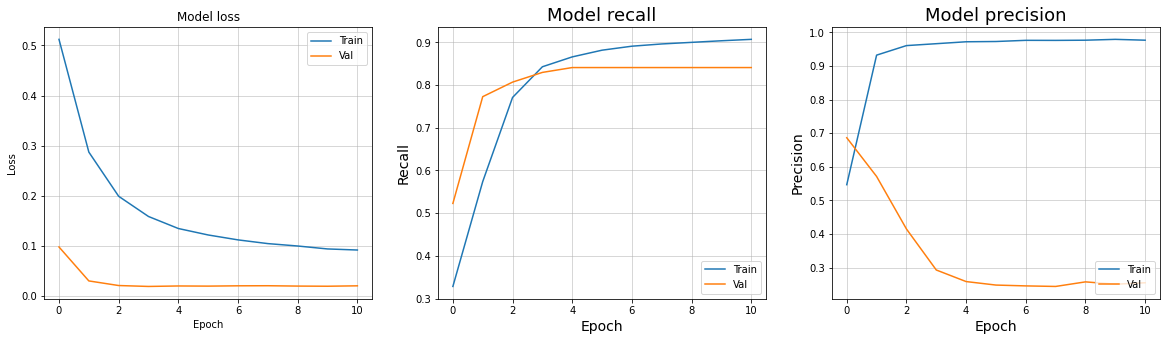

In [0]:
plot_loss_precision_recall_curve(history)

By optimizing on the recall, we are "sacrificing" the precision!

🎯 As a bank manager, you want all the frauds to be detected.

✅ It's fine to predict False Positives, False Alarms: `Better be safe than sorry...`

## 3. Score your model on the unseen Test set

❓ **Question** ❓: Compute your confusion matrix and classification report on the test set

In [0]:
model.evaluate(X_test, y_test, verbose=0, return_dict=True)

In [0]:
y_pred_proba = model.predict(X_test)

In [0]:
threshold = 0.50 # 50% 

y_pred_binary = np.where(y_pred_proba > threshold, 1, 0 )

### Confusion Matrix

In [0]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_binary)
cm

In [0]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_binary))

In [0]:
from sklearn.metrics import precision_recall_curve

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [0]:
plot_prc("Test", y_test, y_pred_proba, linestyle='--')
plt.legend(loc='lower right')

### 🧪 Test your score

Store below your real test performance on a (`X_test`, `y_test`) representative sample of the original unbalanced dataset into `precision` and `recall` variables.

In [0]:
precision =  0.67
recall = 0.75001

In [0]:
from nbresult import ChallengeResult

result = ChallengeResult('solution',
    precision=precision,
    recall=recall,
    fraud_number=len(y_test[y_test == 1]),
    non_fraud_number=len(y_test[y_test == 0]),
)

result.write()
print(result.check())

## 🏁 Optional : Read Google's solution for this challenge
Congratulations for finishing all challenges for this session!

To conclude, take some time to read Google's own solution direcly [on Colab here](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb). 

You will discover interesting techniques and best practices
